*Segment online retail customers based on their purchasing behavior using RFM model and apply KMeans clustering to help the business identify different customer groups for target markign strategies.*

*These are the essential python libraries,pandas,numpy,Data loading, cleaning, and manipulation. matplotlib, seaborn,For plotting graphs & visualizations. Sklearn for preprocessing clustering and evaluation. joblib to save and laod machine learnign model*

In [65]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_score
from  kneed import KneeLocator
import joblib
import streamlit as st 

*Removes missing or canceled invoices. Drop irrelevant columns, stockcode, Description, Country. Converts InvoiceDate to datetime. Creates TotalPrice column: Quantity*UnitPrice. These cleaning setps maks the dataset ready fro RFM analysis.*

In [ ]:

def load_and_clean_data(dataset):

    dataset= pd.read_excel(dataset)
    dataset = dataset.dropna(subset="CustomerID")
    categorical_col_fill = dataset.select_dtypes(include=object).columns
    for col in categorical_col_fill:
        dataset[col].fillna(dataset[col].mode()[0],inplace=True)
    dataset =dataset.drop(["StockCode","Description","Country"],axis=1)
    dataset = dataset[~dataset["InvoiceNo"].astype(str).str.startswith("C")]
    dataset["InvoiceDate"] =pd.to_datetime(dataset["InvoiceDate"])
    dataset["TotalPrice"]=dataset["Quantity"]*dataset["UnitPrice"]
    return dataset

2025-06-15 21:58:54.090 No runtime found, using MemoryCacheStorageManager


*It helps to identify columns with missing data, so we can handle them properly before analysis.*

In [68]:
def vsualization_missing_value(data,titel ="Missing value"):
    missing =data.isna().sum()
    missing =missing[missing>0]
    if not missing.empty:
        plt.figure(figsize=(12,8))
        missing.plot(kind ="bar",color = "tomato")
        plt.title(titel)
        plt.ylabel("Number of missing value")
        plt.xticks(rotation =45)
        plt.tight_layout()
    else:
        print("No Missing value to dispaly")

*A heatmap helps to understand relationships between numeric features. Which cna be useful for feature selection or insight.*

In [69]:
def ploat_Crroleation_Heatmap(corr_matrix,titel = "Crroleation Heatmap"):
    plt.figure(figsize=(5,4))
    sns.heatmap(corr_matrix,annot=True,cmap="coolwarm",fmt=".5f",linewidths=0.5,linecolor="white",vmax=1,vmin=1)
    plt.title(titel)

*The core business analysis step. Receny, how recent was their last purchase. Frequency how foten they purchased. Monetary how much they spent in total it summarizes each customer's behavior in 3 key metrics.*

In [70]:
def create_rfm(df):
    ref_date =df["InvoiceDate"].max()+pd.Timedelta(days = 1)
    rfm = df.groupby("CustomerID").agg({
        "InvoiceDate": lambda x: (ref_date - x.max()).days,
        "InvoiceNo": "nunique",
        "TotalPrice": "sum"
    }).reset_index()
    rfm.columns = ["CustomerID","Recency","Frequency","Monetary"]
    return rfm

*Standardization is needed because RFM values are on different scales. Scaling ensures fairness during clustering.*

In [71]:
def scale_rfm(rfm_data):
    x =rfm_data[["Recency","Monetary","Frequency"]]

    scaler = StandardScaler()
    x_scaler = scaler.fit_transform(x)
    return x_scaler,scaler

*Elbow Method helps detect the poing after which more clusters don't significantly reduce error(WCSS).*

In [72]:
def find_optmal_K(rfm_data):

    
    wcss = []
    k_range = range(1,15)
    for k in k_range:
        kmeans =KMeans(n_clusters=k,random_state=42)
        kmeans.fit(rfm_data)
        wcss.append(kmeans.inertia_)
    kn =KneeLocator(k_range,wcss,curve="convex",direction="decreasing")
    plt.figure(figsize=(6,4))
    plt.plot(k_range,wcss,marker ="o")
    plt.title("Elbow Mthode optimal K")
    plt.xlabel("Number of cluster")
    plt.ylabel("WCSS")
    plt.grid(True)

    return kn.knee

*Silhouette Score measures how well-separated clusters are. The higher the score, the score, the better the separation.*

In [73]:
def plot_silhouette_scores(x_scaler, max_k=10):
    from sklearn.metrics import silhouette_score
    silhouette_scores = []
    K = range(2, max_k + 1)
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(x_scaler)
        score = silhouette_score(x_scaler, labels)
        silhouette_scores.append(score)

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(K, silhouette_scores, marker='o', color='green')
    plt.title("Silhouette Scores for Different K", fontsize=14)
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.grid(True)
    plt.show()

    best_k = K[silhouette_scores.index(max(silhouette_scores))]
    print(f" Best k by Silhouette Score: {best_k}")
    return best_k


*KMeans groups customers inot clusters of similar behavior. Returns cluster labels, centroids, and the fitted model. This is the core ML setp that creates data-driven customer segments.*

In [74]:
def apply_kmeans(x_kmeans,n_clusters):
    kemeans = KMeans(n_clusters=n_clusters,random_state=42)
    x_kmeans= kemeans.fit_predict(x_kmeans)
    
    return x_kmeans,kemeans.cluster_centers_,kemeans

*Gives a quckk overview of each cluster. Average Recency, Frequency, and MOnetary values. Total number of customeers per cluster.Helps stakeholders understand customer groups.*

In [75]:
def cluster_summary(rfm_data):
    
    summary = rfm_data.groupby("Cluster").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "Monetary": "mean",
    "CustomerID": "count"
    }).rename(columns={"CustomerID": "Num_Customers"}).reset_index()

    return summary

*Maps technical cluster numbers to business friendly labes like(VIp Champions,New customers). Helps marketing team take action based on clusters.*

In [76]:
def assign_segment_labels(rfm):
    segment_map = {
        0: "Loyal Customers",
        1: "Lost Customers",
        2: "VIP Champions",
        3: "Potential Customers",
        4: "Big Spenders",
        5: "Other Customers" 
        
    }
    rfm["Segment"] = rfm["Cluster"].map(segment_map)
    new_customer_condition = (rfm["Recency"] <= 30) & (rfm["Frequency"] <= 1)
    rfm.loc[new_customer_condition, "Segment"] = "New Customer"
    return rfm


*Visualize how clusters are distriuted in 2D space. Useful for presentations and understanding cluster spread.*

In [77]:
def plot_cluster(rfm_scaled_data,centers):

    colors =["red","green","blue","cyan"]
    plt.figure(figsize=(10, 6))
    for i in rfm_scaled_data["Cluster"].unique():
        cluster_data = rfm_scaled_data[rfm_scaled_data["Cluster"] == i]
        sns.scatterplot(x = cluster_data["Recency"],y =cluster_data["Monetary"],label =f"Cluster{i}",color=colors[i % len(colors)])
    plt.scatter(x=centers[:, 0], y=centers[:, 2], marker="*", s=200, color="black", label="Centroid")
    plt.title("Cluster Visualization (scaled)", fontsize=14)
    plt.xlabel("Recency (scaled)")
    plt.ylabel("Monetary (scaled)")
    plt.grid(True)
    plt.show()

*Shows the size of each segment in a bar chart. Helps in planning target marketing efforts.*

In [78]:
def segment_distibution(distibution):
    segment_counts = distibution["Segment"].value_counts()
    plt.figure(figsize=(10, 6))
    segment_counts.plot(kind="bar", color="skyblue")
    plt.title("Customer Segment Distribution")
    plt.xlabel("Segment")
    plt.ylabel("Number of Customers")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

*Saves trained scaler and model. Allows future predictions without retraining. Enables deployment or intergration in production*

In [62]:
scaler =joblib.load("scaler.joblib")
kmeans = joblib.load("kmeans_model.joblib")

*Takes new customer RFM data and predicts which segment they belogn to. Usful for onboarding or offering tailored services to new users.*

In [63]:
def new_customer_Predicted(recency, frequency, monetary):
    new_data =np.array([[recency, frequency, monetary]])
    new_data_scaled = scaler.transform(new_data)
    clusters =kmeans.predict(new_data_scaled)
    return clusters[0]

*This functions connets all the steps inot one smooth workflow from loading data to saving models and making predictions.*

No Missing value to dispaly


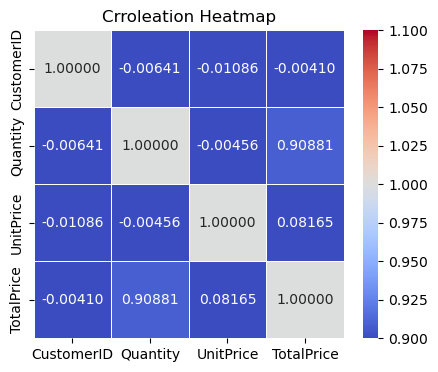

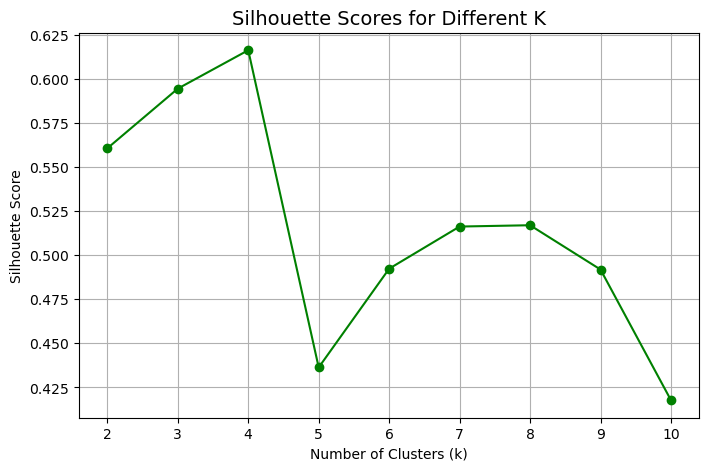

 Best k by Silhouette Score: 4
Optimal k number of cluster:6
   Cluster     Recency   Frequency       Monetary  Num_Customers
0        0   33.044231    4.074456    1519.511719           2713
1        1  294.123200    1.300800     405.754576            625
2        2   15.677215   25.025316   15615.259747            158
3        3  150.757212    2.084135     702.949641            832
4        4    7.666667   43.000000  190863.461667              6
5        5    1.600000  144.600000   67626.018000              5
      CustomerID  Recency  Frequency  Monetary  Cluster              Segment
0        12346.0      326          1  77183.60        2        VIP Champions
1        12347.0        2          7   4310.00        0      Loyal Customers
2        12348.0       75          4   1797.24        0      Loyal Customers
3        12349.0       19          1   1757.55        0         New Customer
4        12350.0      310          1    334.40        1       Lost Customers
...          ...      

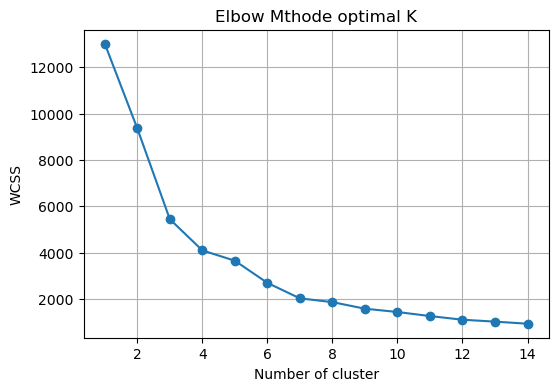

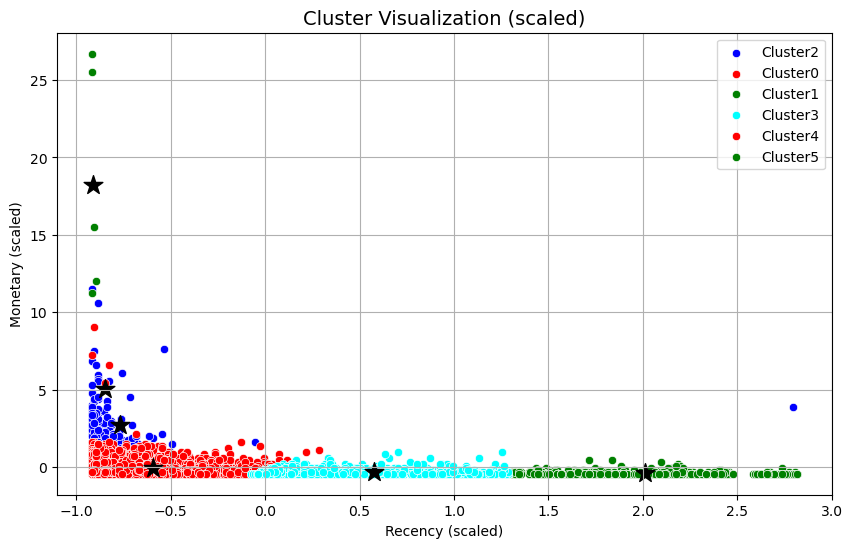

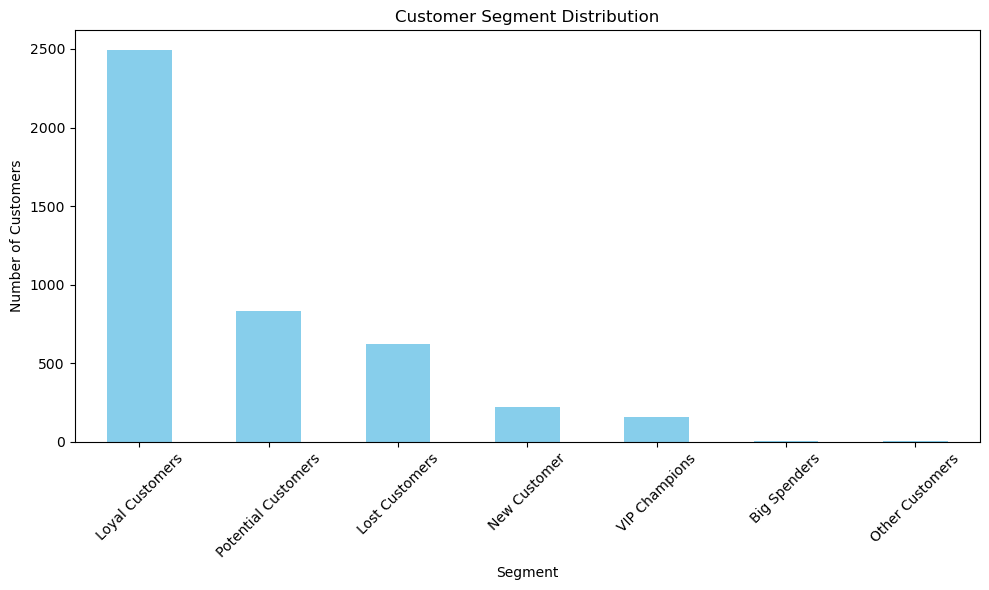

New Customer to belong cluster:5


In [64]:
def main_code():
    dataset=load_and_clean_data("Online Retail.xlsx")
    vsualization_missing_value(dataset)


    corr_matrix = dataset[["CustomerID", "Quantity", "UnitPrice", "TotalPrice"]].corr()
    ploat_Crroleation_Heatmap(corr_matrix)
    rfm = create_rfm(dataset)
    x_scaler,scaler =scale_rfm(rfm)

    best_k=plot_silhouette_scores(x_scaler, max_k=10)
    
    optimal_k = find_optmal_K(x_scaler)
    print(f"Optimal k number of cluster:{optimal_k}")
    
    cluster_label,center,kmeans_model =apply_kmeans(x_scaler,optimal_k)
    rfm["Cluster"] = cluster_label

    summary =cluster_summary(rfm)
    print(summary)

    rfm_labeled = assign_segment_labels(rfm)
    print(rfm_labeled)
    new_customer_count = rfm_labeled[rfm_labeled["Segment"] == "New Customer"].shape[0]
    print(f"Total number of New Customers: {new_customer_count}")

    joblib.dump(scaler, "scaler.joblib")
    joblib.dump(kmeans_model, "kmeans_model.joblib")

    rfm_scaled_data = pd.DataFrame(x_scaler, columns=["Recency","Frequency", "Monetary"])
    rfm_scaled_data["Cluster"] = rfm["Cluster"]
    
    plot_cluster(rfm_scaled_data,center)
    segment_distibution(rfm_labeled)

    cluster_num =new_customer_Predicted( 75,4,1797.24)
    print(f"New Customer to belong cluster:{cluster_num}")

if __name__ == "__main__":
    main_code()